# [Blackjack](https://en.wikipedia.org/wiki/Blackjack)

The object of the popular casino card game of blackjack is to obtain cards the sum of whose numerical values is as great as possible without exceeding 21.
- All face cards count as 10, and an ace can count either as 1 or as 11.
- We consider the version in which each player competes independently against the dealer.
- The game begins with 2 cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down. 
- If the player:
  -  has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw.
  -  does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust).
  -  goes bust, he loses; if he sticks, then it becomes the dealer’s turn.
- The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise.
  -  If the dealer goes bust, then the player wins; otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21.

In [1]:
from IPython.display import Image

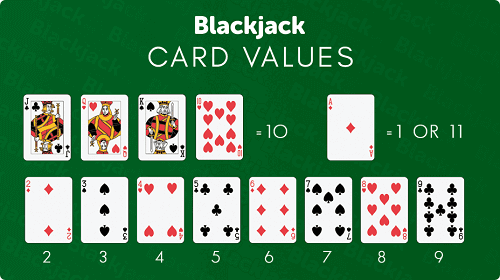

In [2]:
Image(filename='../book_images/blackjack-card-values.png')

Playing blackjack is naturally formulated as an episodic finite MDP.
- Each game of blackjack is an episode.
- Rewards of +1, -1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are 0, and we do not discount ($\gamma = 1$) => these terminal rewards are also the returns.
- The player’s actions are to hit or to stick.
- The states depend on the player’s cards and the dealer’s showing card.
  -  We assume that cards are dealt from an infinite deck (i.e., with replacement) so that there is no advantage to keeping track of the cards already dealt.
- If the player holds an ace that he could count as 11 without going bust, then the ace is said to be usable.
  -  In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit.
  -  Thus, the player makes decisions on the basis of 3 variables:
    1. his current sum (12–21),
    2. the dealer’s one showing card (ace–10),
    3. whether he holds a usable ace.
This makes for a total of 200 states.

Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.
- To find the state-value function for this policy by a Monte Carlo approach, one simulates many blackjack games using the policy and averages the returns following each state.
- In this way, we obtained the estimates of the state-value function shown in Figure 5.1.
- The estimates for states with a usable ace are less certain and less regular because these states are less common.
- In any event, after 500,000 games the value function is very well approximated.

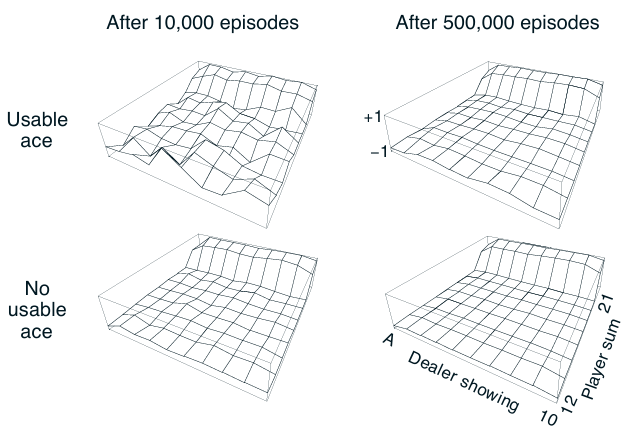

In [3]:
Image(filename='../book_images/Figure_5_1.PNG')

Figure 5.1: Approximate state-value functions for the blackjack policy that sticks only on 20 or 21, computed by Monte Carlo policy evaluation.

- Although we have complete knowledge of the environment in the blackjack task, it would not be easy to apply DP methods to compute the value function.
- DP methods require the distribution of next events — in particular, they require the environments dynamics as given by the 4-argument function $p$ — and it is not easy to determine this for blackjack.
- For example, suppose the player’s sum is 14, and he chooses to stick.
  -  What is his probability of terminating with a reward of +1 as a function of the dealer’s showing card?
  -  All the probabilities must be computed before DP can be applied, and such computations are often complex and error-prone. 
- In contrast, generating the sample games required by MCMs is easy.
- This is the case surprisingly often; the ability of MCMs to work with sample episodes alone can be a significant advantage even when one has complete knowledge of the environment’s dynamics.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

matplotlib.use('Agg')

## Monte Carlo Prediction

In [3]:
from src.black_jack import monte_carlo_on_policy

In [6]:
# Get sample-average of returns of states with usable ace and with no usable ace for 10000 episodes
states_usable_ace_1, states_no_usable_ace_1 = monte_carlo_on_policy(episodes=10000)

# Get sample-average of returns of states with usable ace and with no usable ace for 500000 episodes
states_usable_ace_2, states_no_usable_ace_2 = monte_carlo_on_policy(episodes=500000)

100%|██████████| 500000/500000 [00:07<00:00, 69473.54it/s]


In [7]:
states = [states_usable_ace_1, states_usable_ace_2, states_no_usable_ace_1, states_no_usable_ace_2]
titles = ['Usable Ace, 10000 Episodes', 'Usable Ace, 500000 Episodes',
          'No Usable Ace, 10000 Episodes', 'No Usable Ace, 500000 Episodes']

In [8]:
# Plotting
_, axes = plt.subplots(2, 2, figsize=(40, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

In [9]:
for state, title, axis in zip(states, titles, axes):
    fig = sns.heatmap(np.flipud(state), cmap="YlGnBu", ax=axis, annot=True, xticklabels=range(1, 11), yticklabels=list(reversed(range(12, 22))))
    fig.set_ylabel('Player Sum', fontsize=30)
    fig.set_xlabel('Dealer Showing', fontsize=30)
    fig.set_title(title, fontsize=30)

In [10]:
plt.savefig('../generated_images/figure_5_1.png')
plt.close()

## Monte Carlo Control

It is straightforward to apply Monte Carlo Exploring Starts (MC ES) to blackjack.
- Because the episodes are all simulated games, it is easy to arrange for exploring starts that include all possibilities.
- In this case one simply picks the dealer’s cards, the player’s sum, and whether the player has a usable ace, all at random with equal probability.
- As the initial policy we use the policy evaluated in the previous blackjack example, that which sticks only on 20 or 21.
- The initial action-value function can be 0 for all state–action pairs.
- Figure 5.2 shows the optimal policy for blackjack found by MC ES.
  -  This policy is the same as the “basic” strategy of Thorp (1966) with the sole exception of the leftmost notch in the policy for a usable ace, which is not present in Thorp’s strategy.
- We are uncertain of the reason for this discrepancy, but confident that what is shown here is indeed the optimal policy for the version of blackjack we have
 described.

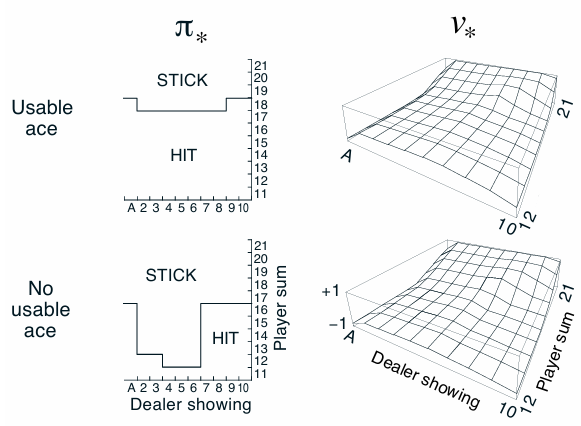

In [11]:
Image(filename='../book_images/Figure_5_2.PNG')

Figure 5.2: The optimal policy and state-value function for blackjack, found by MC ES. The state-value function shown was computed from the action-value function found by MC ES.

In [3]:
from src.black_jack import monte_carlo_es

In [4]:
# Get sample-average of state-action values for 500000 episodes
state_action_values = monte_carlo_es(episodes=500000)

state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

100%|██████████| 500000/500000 [00:43<00:00, 11423.01it/s]


In [5]:
# Get the optimal policy
action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

In [6]:
images = [action_usable_ace, state_value_usable_ace, action_no_usable_ace, state_value_no_usable_ace]
titles = ['Optimal policy with usable Ace', 'Optimal value with usable Ace',
          'Optimal policy without usable Ace', 'Optimal value without usable Ace']

In [7]:
# Plotting
_, axes = plt.subplots(2, 2, figsize=(40, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

In [8]:
for image, title, axis in zip(images, titles, axes):
    fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, annot=True, xticklabels=range(1, 11), yticklabels=list(reversed(range(12, 22))))
    fig.set_ylabel('player sum', fontsize=30)
    fig.set_xlabel('dealer showing', fontsize=30)
    fig.set_title(title, fontsize=30)

In [9]:
plt.savefig('../generated_images/figure_5_2.png')
plt.close()

## Off-policy Prediction via Importance Sampling

- We applied both ordinary and weighted importance-sampling methods to estimate the value of a single blackjack state (Example 5.1) from off-policy data.
- Recall that one of the advantages of MCMs is that they can be used to evaluate a single state without forming estimates for any other states.
- In this example, we evaluated the state in which the dealer is showing a deuce, the sum of the player’s cards is 13, and the player has a usable ace (that is, the player holds an ace and a deuce, or equivalently 3 aces).
  - The data was generated by starting in this state then choosing to hit or stick at random with equal probability (the behavior policy).
  - The target policy was to stick only on a sum of 20 or 21, as in Example 5.1.
  - The value of this state under the target policy is approximately 0.27726 (this was determined by separately generating one-hundred million episodes using the target policy and averaging their returns).
  - Both off-policy methods closely approximated this value after 1000 off-policy episodes using the random policy.
  - To make sure they did this reliably, we performed 100 independent runs, each starting from estimates of 0 and learning for 10,000 episodes.
- Figure 5.3 shows the resultant learning curves—the squared error of the estimates of each method as a function of number of episodes, averaged over the 100 runs.
  - The error approaches 0 for both algorithms, but the weighted importance-sampling method has much lower error at the beginning, as is typical in practice.

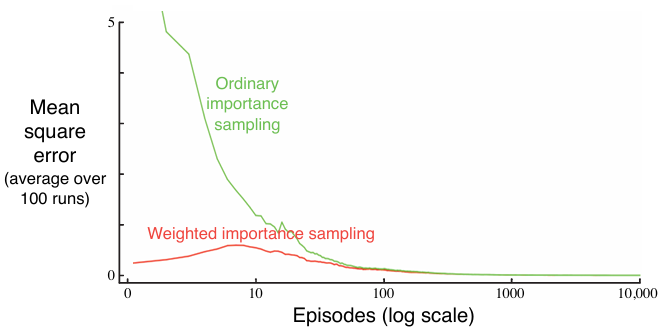

In [3]:
Image(filename='../book_images/Figure_5_3.PNG')

Figure 5.3: Weighted importance sampling produces lower error estimates of the value of a single blackjack state from off-policy episodes.

In [4]:
from src.black_jack import monte_carlo_off_policy

In [5]:
true_value = -0.27726
episodes = 10000
runs = 100

In [6]:
error_ordinary = np.zeros(episodes)
error_weighted = np.zeros(episodes)

In [7]:
for i in tqdm(range(0, runs)):
    ordinary_sampling_, weighted_sampling_ = monte_carlo_off_policy(episodes)
    # get the squared error
    error_ordinary += np.power(ordinary_sampling_ - true_value, 2)
    error_weighted += np.power(weighted_sampling_ - true_value, 2)
error_ordinary /= runs
error_weighted /= runs

100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


In [8]:
# Plotting
plt.plot(np.arange(1, episodes + 1), error_ordinary, color='green', label='Ordinary Importance Sampling')
plt.plot(np.arange(1, episodes + 1), error_weighted, color='red', label='Weighted Importance Sampling')
plt.ylim(-0.1, 5)
plt.xlabel('Episodes (log scale)')
plt.ylabel(f'Mean square error\n(average over {runs} runs)')
plt.xscale('log')
plt.legend()

In [9]:
plt.savefig('../generated_images/figure_5_3.png')
plt.close()